## Predictive Analytics 
#### Load Packages 

In [2]:
import sqlite3 #Daten einholen

import pandas as pd #Daten analysieren
import numpy as np #Daten analysieren

import matplotlib.pyplot as plt #Daten visualisieren
import seaborn as sns #Daten visualisieren
import plotly.express as px #Daten visualisieren
import plotly.graph_objects as go #Daten visualisieren

from datetime import datetime #Daten formatieren

from sklearn.linear_model import LinearRegression #Machine Learning
import statsmodels.api as sm  #Statistische Modelle
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing #Time Series Analysis
import statsmodels.tsa.api as tsa #Time Series Analysis

## Database Connection

In [3]:

con = sqlite3.connect('oth_shpm.db')

customer = pd.read_sql_query("SELECT * FROM customer", con)
plant = pd.read_sql_query("SELECT * FROM plant", con)
shipment = pd.read_sql_query("SELECT * FROM shipment", con)

con.close()

## Data Wrangling 

In [4]:
shpm= (
    shipment
    .merge(customer, left_on='Ship-to2', right_on='ID', suffixes=('','_customer'))

    .merge(plant, left_on='Plant', right_on='ID', suffixes=('_customer','_plant'))

    .assign(del_date = lambda df: pd.to_datetime(
        df['Delivery_day'].astype(str).str.strip(),
        format="%d.%m.%Y",
        errors="coerce"
    )) 
)

## Time Series Aggregation

<Axes: xlabel='del_date', ylabel='GWkg'>

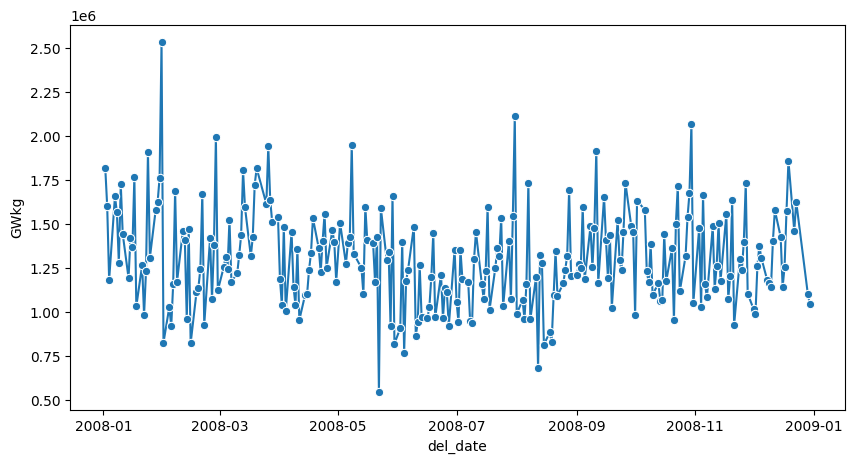

In [5]:
shpm_ts = (
    shpm
    .groupby ('del_date', as_index=False)
    .agg ( GWkg = ('GWkg', lambda x: x.sum (skipna=True)))
)


plt.figure (figsize=(10, 5))
sns.lineplot(data=shpm_ts, x='del_date', y='GWkg', marker='o')

#### simple linear regresseion

 Linear Regression Model:
Intercept: 1346518.2422921646, Coefficient: -321.45825358007005
Predictions: [1265189.30413641 1264867.84588283 1264546.38762925]


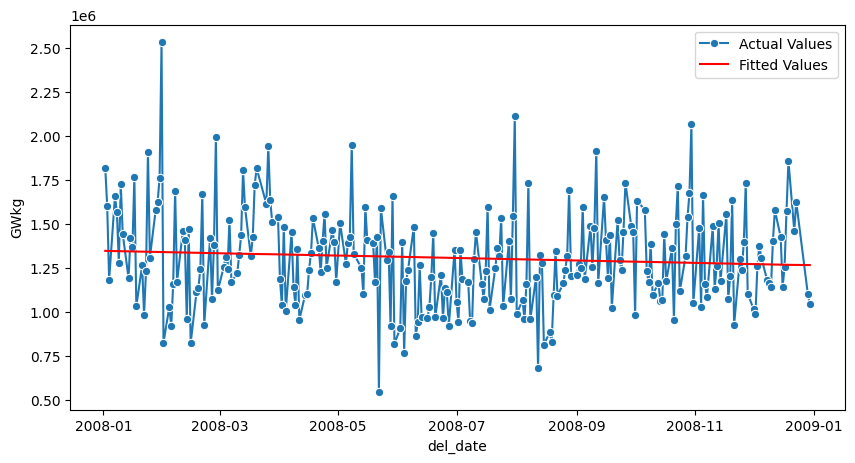

In [6]:
shpm_ts['wdays'] = np.arange(1, len(shpm_ts)+1)

y = shpm_ts['GWkg']
X= shpm_ts [['wdays']]

model = LinearRegression()
model.fit (X, y) 

print(" Linear Regression Model:")
print(f"Intercept: {model.intercept_}, Coefficient: {model.coef_[0]}")


# ---- Predict Future Values ----
new_days = pd.DataFrame ({'wdays': [253,254,255]})
pred_01= model.predict (new_days)
print("Predictions:" , pred_01)

plt.figure (figsize=(10, 5))
sns.lineplot(data=shpm_ts, x='del_date', y='GWkg', marker='o', label= 'Actual Values')
plt.plot(shpm_ts['del_date'], model.predict(X), color='red', label= 'Fitted Values')
plt.legend()
plt.show()

#### Multiple Regresseion

In [7]:
us_change = pd.read_csv("oth_data/us_change.csv", sep=";", decimal =",")

x = us_change [["Income","Production","Savings","Unemployment"]]
y = us_change ["Consumption"]

x= sm.add_constant (x)
mlr_model= sm.OLS(y,x).fit()
print(mlr_model.summary())


new_data= pd.DataFrame ({'Income': [1,2,3], 'Production': [1,2,3], 'Savings': [1,2,3], 'Unemployment': [1,2,3]})

new_data= sm.add_constant (new_data)
pred_02= mlr_model.predict (new_data)
print("Multiple Linear Regression Predictions:" , pred_02)

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     160.0
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           3.93e-60
Time:                        08:38:15   Log-Likelihood:                -46.660
No. Observations:                 198   AIC:                             103.3
Df Residuals:                     193   BIC:                             119.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2531      0.034      7.343   

#### Multiple Regression with dummy variables 

                            OLS Regression Results                            
Dep. Variable:                   GWkg   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     16.96
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           2.11e-14
Time:                        08:38:20   Log-Likelihood:                -3480.3
No. Observations:                 252   AIC:                             6973.
Df Residuals:                     246   BIC:                             6994.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.22e+06   4.37e+04     27.920      0.0

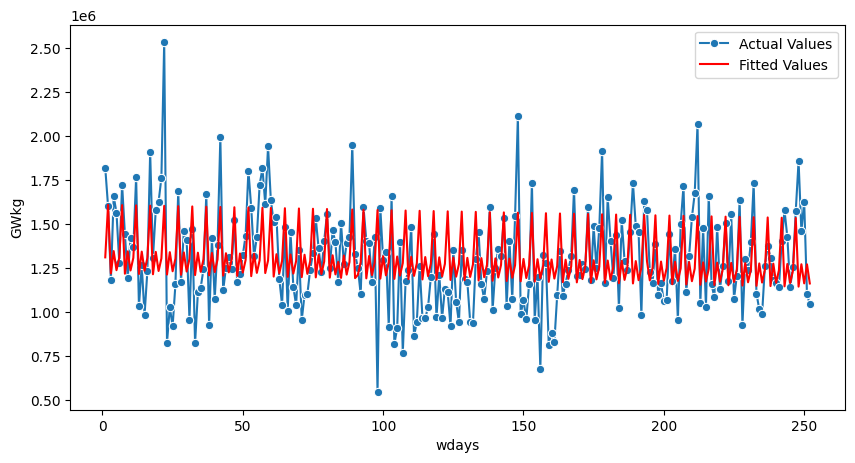

In [8]:
shpm_ts["week_day"] = shpm_ts["del_date"].dt.day_name()

week_dummies = pd.get_dummies(shpm_ts["week_day"], drop_first=True).astype(int)
shpm_ts = pd.concat([shpm_ts[["wdays", "GWkg"]], week_dummies], axis=1)

x= shpm_ts.drop(columns=["GWkg"])
x=sm.add_constant(x)
y= shpm_ts["GWkg"]

lm_dummy = sm.OLS(y,x).fit()
print(lm_dummy.summary())

plt.figure (figsize=(10, 5))
sns.lineplot(x=shpm_ts['wdays'], y=shpm_ts['GWkg'], marker='o', label='Actual Values')
plt.plot(shpm_ts['wdays'], lm_dummy.fittedvalues, color='red', label='Fitted Values')
plt.legend()
plt.show()

#### Advanced Techniques 

In [ ]:
from sklearn.model_selection import train_test_split


temp = (
    shpm
    .groupby("del_date", as_index=False)
    .agg(sum_tons = ("GWkg", lambda x: np.nansum(x)/1000))
    .sort_values("del_date")
)

temp ["week_day"] = temp ["del_date"].dt.day_name()

temp ["working_day"] =np.arange(1, len(temp)+1)

temp["Di"] = (temp["week_day"] == "Tuesday").astype(int)
temp["Mi"] = (temp["week_day"] == "Wednesday").astype(int)
temp["Do"] = (temp["week_day"] == "Thursday").astype(int)
temp["Fr"] = (temp["week_day"] == "Friday").astype(int)
temp["Sa"] = (temp["week_day"] == "Saturday").astype(int)
temp["So"] = (temp["week_day"] == "Sunday").astype(int)

temp_1 =temp.drop(columns=["del_date","week_day"])


temp_1



share_train = 0.8 
np.random.seed(100)
shpm_train, shpm_test = train_test_split(temp_1, train_size=share_train, random_state=100)

X_train1 =shpm_train[["working_day"]]
X_train2 =shpm_train[["working_day","Di","Mi","Do","Fr","Sa","So"]]
X_train3=shpm_train[["Di","Mi","Do","Fr","Sa","So"]]
y_train = shpm_train["sum_tons"]

def fit_ols_model(X,y):
    X = sm.add_constant(X)
    model = sm.OLS(y,X).fit()
    return model



mod_1 = fit_ols_model(X_train1,y_train)
mod_2 = fit_ols_model(X_train2,y_train)
mod_3 = fit_ols_model(X_train3,y_train)



